cuda:7
For Optimizer: Adam and Starting LR: 1e-06
 Epoch 1, Train Loss: 2.9308, Val Acc: 0.2190
 Epoch 2, Train Loss: 2.7048, Val Acc: 0.2476
 Epoch 3, Train Loss: 2.5186, Val Acc: 0.2619
 Epoch 4, Train Loss: 2.3676, Val Acc: 0.2810
 Epoch 5, Train Loss: 2.2423, Val Acc: 0.2952
 Epoch 6, Train Loss: 2.1140, Val Acc: 0.3190
 Epoch 7, Train Loss: 2.0162, Val Acc: 0.3429
 Epoch 8, Train Loss: 1.9338, Val Acc: 0.3476
 Epoch 9, Train Loss: 1.8418, Val Acc: 0.3762
 Epoch 10, Train Loss: 1.7584, Val Acc: 0.3952
 Epoch 11, Train Loss: 1.6915, Val Acc: 0.3952
 Epoch 12, Train Loss: 1.6316, Val Acc: 0.4048
 Epoch 13, Train Loss: 1.5568, Val Acc: 0.4048
 Epoch 14, Train Loss: 1.4900, Val Acc: 0.4190
 Epoch 15, Train Loss: 1.4253, Val Acc: 0.4714
 Epoch 16, Train Loss: 1.3631, Val Acc: 0.4857
 Epoch 17, Train Loss: 1.3060, Val Acc: 0.4714
 Epoch 18, Train Loss: 1.2555, Val Acc: 0.4667
 Epoch 19, Train Loss: 1.2158, Val Acc: 0.4857
 Epoch 20, Train Loss: 1.1778, Val Acc: 0.4857
 Epoch 21, Train Lo

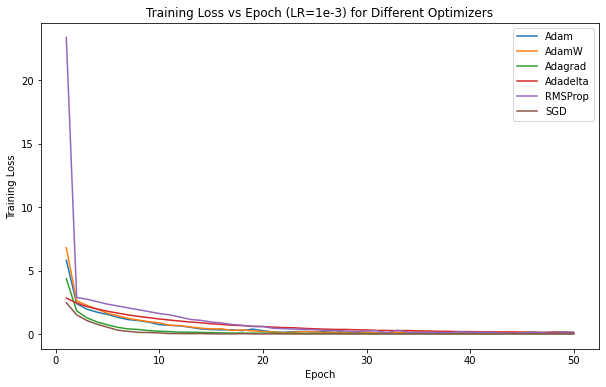

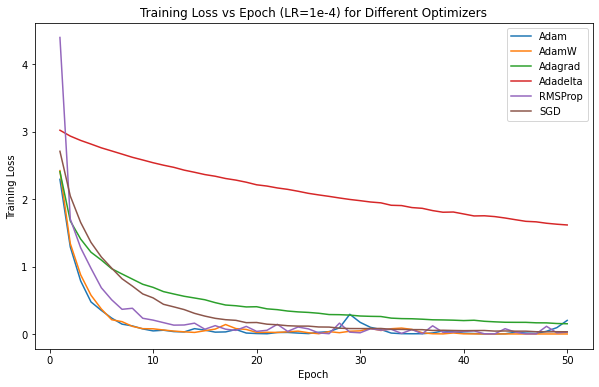

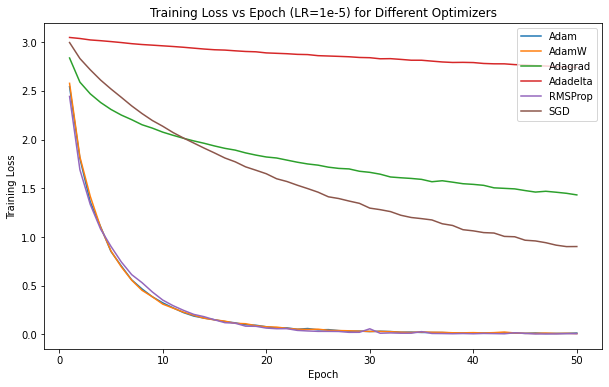

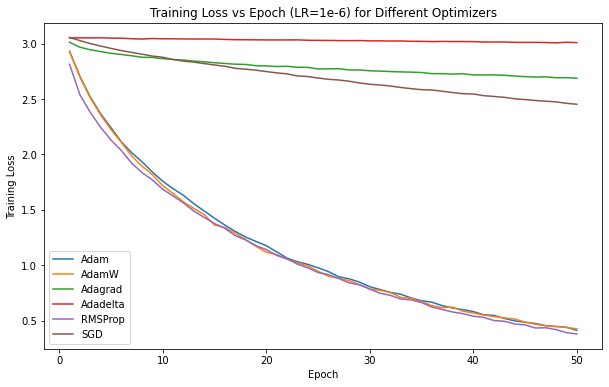

Classification Report:
                    precision    recall  f1-score   support

     agricultural       1.00      0.74      0.85        27
         airplane       0.59      0.85      0.70        26
  baseballdiamond       1.00      0.95      0.98        21
            beach       1.00      1.00      1.00        22
        buildings       0.17      0.33      0.22        12
        chaparral       0.95      1.00      0.98        21
 denseresidential       0.75      0.44      0.56        27
           forest       0.78      0.95      0.86        19
          freeway       0.77      0.74      0.76        23
       golfcourse       0.68      0.81      0.74        16
           harbor       1.00      0.89      0.94        18
     intersection       0.61      0.95      0.74        21
mediumresidential       0.60      0.58      0.59        26
   mobilehomepark       0.88      0.82      0.85        17
         overpass       0.84      0.76      0.80        21
       parkinglot       1.00   

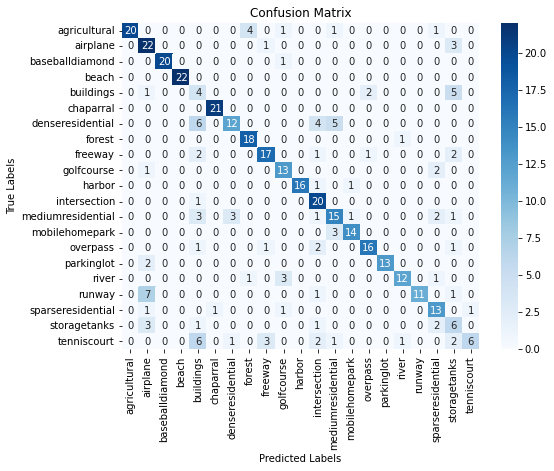

Best model (Optimizer: Adam, LR: 0.0001) val accuracy: 0.8095238095238095 test accuracy: 0.7387


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Loading the dataset
data_dir = "Images"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Data Split into train (70%), val (10%), test (20%)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Our CNN which we used in assignment 3
class small_CNN(nn.Module):
    def __init__(self):
        super(small_CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch norm

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fifth convolutional layer
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()  # ReLU activation
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling

        # Fully connected layer which flattens to 512
        self.fc1 = nn.Linear(512 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 21) # Output layer

    def forward(self, x):
        # First conv layer, batch norm, ReLU & max pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        # Second conv layer, batch norm, ReLU & max pooling
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # Third conv layer, batch norm, ReLU & max pooling
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        # Fourth conv layer, batch norm, ReLU & max pooling
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        # Fifth conv layer, batch norm, ReLU & max pooling
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        #  Fully connected layer with ReLU
        x = self.relu(self.fc1(x))
        # Final output layer
        x = self.fc2(x)
        return x

# Main training function
def train_model(model, optimizer, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss() # CE Loss for classification
    best_acc = 0.0
    best_model = None
    epoch_losses = []  # To store average training loss per epoch
    for epoch in range(epochs):  # Training over epochs
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader: # Iterating through train dataset
            images, labels = images.to(device), labels.to(device) # Moving tensors to GPU
            optimizer.zero_grad() # Setting gradients to zero before backpropagation
            outputs = model(images) # Feeding images to model
            loss = criterion(outputs, labels) # CE loss on preds and labels
            loss.backward() # Gradient computation
            optimizer.step() # Weight update based on gradient
            train_loss += loss.item() # Total loss
            _, predicted = outputs.max(1) # Getting index with max probability
            correct += predicted.eq(labels).sum().item() # Number of correct preds by comparing with true label
            total += labels.size(0) # Total samples
        
        avg_loss = train_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        val_acc = evaluate_model(model, val_loader) # Val accuracy
        if val_acc > best_acc:  # Getting best val acc
            best_acc = val_acc # Best val acc
            best_model = model.state_dict() # Best model state
        print(f" Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return best_model, best_acc, epoch_losses

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # Disabling gradient calculation for val
        for images, labels in loader:  # Iterating through val dataset
            images, labels = images.to(device), labels.to(device) # Moving tensors to GPU
            outputs = model(images) # Feeding images to model
            _, predicted = outputs.max(1) # Getting index with max probability
            correct += predicted.eq(labels).sum().item()  # Number of correct preds by comparing with true label
            total += labels.size(0) # Total samples
    return correct / total

def test_eval(model, loader, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Disabling gradient calculation for testing
        for images, labels in loader:  # Iterating through test dataset
            images, labels = images.to(device), labels.to(device) # Moving tensors to GPU
            outputs = model(images) # Feeding images to model
            _, predicted = outputs.max(1) # Getting index with max probability
            correct += predicted.eq(labels).sum().item()  # Number of correct preds by comparing with true label
            total += labels.size(0) # Total samples
            
            all_preds.extend(predicted.cpu().numpy()) #Tensor to array
            all_labels.extend(labels.cpu().numpy()) # Tensor to array

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return correct / total

# List of optimizers and starting learning rates to try as hparams
optimizers_list = ["Adam", "AdamW", "Adagrad", "Adadelta", "RMSProp", "SGD"]
lrs = [1e-6, 1e-5, 1e-4, 1e-3]  # Different starting learning rates
best_acc = 0.0
best_params = None
best_model_state = None
hist3 = {}  # To store loss vs epoch for lr = 1e-3
hist4 = {}  # To store loss vs epoch for lr = 1e-4
hist5 = {}  # To store loss vs epoch for lr = 1e-5
hist6 = {}  # To store loss vs epoch for lr = 1e-6

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

print(device)

# Loop over optimizer and lr pairs
for opt in optimizers_list:
    for lr in lrs:
        print(f"For Optimizer: {opt} and Starting LR: {lr}")
        model = small_CNN().to(device)
        
        if opt == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        elif opt == "Adagrad":
            optimizer = optim.Adagrad(model.parameters(), lr=lr)
        elif opt == "Adadelta":
            optimizer = optim.Adadelta(model.parameters(), lr=lr)
        elif opt == "RMSProp":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif opt == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        # Train model for current optimizer-lr pair
        epochs = 50
        model_state, val_acc, epoch_losses = train_model(model, optimizer, train_loader, val_loader, epochs)
        
        # Saving training loss history for a particular starting lr across different optimizers
        if lr == 1e-3:
            hist3[opt] = epoch_losses
        if lr == 1e-4:
            hist4[opt] = epoch_losses
        if lr == 1e-5:
            hist5[opt] = epoch_losses
        if lr == 1e-6:
            hist6[opt] = epoch_losses

        # Update best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_params = (opt, lr)
            best_model_state = model_state

# Loss vs epoch for different optimizers at lr=1e-3
plt.figure(figsize=(10, 6))
for opt, losses in hist3.items():
    plt.plot(range(1, epochs+1), losses, label=opt)  # Plot each optimizer's training loss curve
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (LR=1e-3) for Different Optimizers")
plt.legend()
plt.show()
            
            
# Loss vs epoch for different optimizers at lr=1e-4
plt.figure(figsize=(10, 6))
for opt, losses in hist4.items():
    plt.plot(range(1, epochs+1), losses, label=opt)  # Plot each optimizer's training loss curve
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (LR=1e-4) for Different Optimizers")
plt.legend()
plt.show()

# Loss vs epoch for different optimizers at lr=1e-5
plt.figure(figsize=(10, 6))
for opt, losses in hist5.items():
    plt.plot(range(1, epochs+1), losses, label=opt)  # Plot each optimizer's training loss curve
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (LR=1e-5) for Different Optimizers")
plt.legend()
plt.show()
            
            
# Loss vs epoch for different optimizers at lr=1e-6
plt.figure(figsize=(10, 6))
for opt, losses in hist6.items():
    plt.plot(range(1, epochs+1), losses, label=opt)  # Plot each optimizer's training loss curve
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (LR=1e-6) for Different Optimizers")
plt.legend()
plt.show()

# Testing using the best model
best_optimizer_name, best_lr = best_params
best_model = small_CNN().to(device)
best_model.load_state_dict(best_model_state)
class_names = dataset.classes  # Getting class names from the dataset
test_acc = test_eval(best_model, test_loader, class_names)
print(f"Best model (Optimizer: {best_optimizer_name}, LR: {best_lr}) val accuracy: {best_acc} test accuracy: {test_acc:.4f}")
